<a href="https://colab.research.google.com/github/Isadorarv26/Isadorarv26/blob/main/ProyectoFinalML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EAE3709 APLICACIONES DE  MACHINE LEARNING EN ECONOMÍA <br>


# **Proyecto Final: Predicción de cierre de Areopuerto de La Serena**

---

Integrantes:
- Isadora Rosas
- Nicolás Salas
- Diego Salas

Fecha de entrega: 29-06-2025

Nuestro proyecto se basa en la evaluación de datos metereológicos METAR para poder predecir si un aeropuerto estará o no disponible en base a la visibilidad por nubosidad con la que se cuente ese día a esa hora. En particular se realiza un análisis del aeropuerto de La Serena pues se está evaluando un proyecto de mejora de infrastructura que considera instalación de luces en pista para poder disponibilizar el aeropuerto con una menor visibilidad, y es por ello que una predicción de cuanto tiempo el aeropuesto no se encuntra disponible por baja nubosidad es relevante de analizar.

Nuestra fuente de información prinicipal son bases de datos METAR disponibles en distintas páginas de metereología, y el conocimiento técnico de los umbrales de visibilidad proviene de la jefa de proyectos PBN de LATAM dedicada al diseño de procedimientos instrumentales.

Este avance del proyecto se basará en presentar el EDA de la base de datos en cuestión

Base de datos obtenida desde la web: https://www.mesonet.agron.iastate.edu/request/download.phtml?

## Data frame


In [ ]:
#carga de las principales librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#URL del dataset
url = "https://www.mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SCSE&data=all&year1=2010&month1=1&day1=1&year2=2024&month2=12&day2=31&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=1&report_type=3&report_type=4"

#importación del dataset
df_metar = pd.read_csv(url)


/tmp/ipython-input-65-1403945558.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metar = pd.read_csv(url)


## Exploratory data analysis (EDA)


In [ ]:
#muestra de las primeras columnas del dataset
df_metar.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,SCSE,2010-01-01 00:00,60.8,55.4,82.37,310.0,7.0,NaN,30.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.8,SCSE 010000Z AUTO 31007KT 16/13 A3000 RMK T016...,NaN
1,SCSE,2010-01-01 01:00,59.0,55.4,87.83,290.0,5.0,NaN,30.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,SCSE 010100Z AUTO 29005KT 15/13 A3000 RMK T015...,NaN
2,SCSE,2010-01-01 02:00,59.0,55.4,87.83,300.0,3.0,NaN,30.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,SCSE 010200Z AUTO 30003KT 15/13 A3000 RMK T015...,NaN
3,SCSE,2010-01-01 03:00,59.0,55.4,87.83,270.0,3.0,NaN,30.03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,SCSE 010300Z AUTO 27003KT 15/13 A3003 RMK T015...,NaN
4,SCSE,2010-01-01 04:00,59.0,55.4,87.83,270.0,1.0,NaN,30.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,SCSE 010400Z AUTO 27001KT 15/13 A3000 RMK T015...,NaN


In [ ]:
#análisis de los tipos de datos
df_metar.dtypes

,0
station,object
valid,object
tmpf,float64
dwpf,float64
relh,float64
drct,float64
sknt,float64
p01i,float64
alti,float64
mslp,float64


- Muestra variable de interes es **vsby**: visibilidad en millas. La regulación indica que por bajo de cierto nivel de visibilidad no pueden aterrizar vuelos del aeropuerto.

## Auto correlación de vsby

Es posible que exista autocorrelación temporal con vsby, es decir que es una variable que en el tiempo puede depender en cierto grado de sus valores pasados, vsby en el momento t no sigue una distribución completamente aleatoria. Ante esto, se incorporarán variables que indiquen visibilidad de 3 momentos anteriores a t, esto puede ser un input más valido a los modelos en comparación a incluir únicamente vsby en el momento t.

In [ ]:
df_metar = df_metar.sort_values('valid')  #orden temporal

#variables previas a momento t
df_metar['vsby_t-1'] = df_metar['vsby'].shift(1)
df_metar['vsby_t-2'] = df_metar['vsby'].shift(2)
df_metar['vsby_t-3'] = df_metar['vsby'].shift(3)


In [ ]:
df_metar[['valid', 'vsby', 'vsby_t-1', 'vsby_t-2', 'vsby_t-3']].head(10)  #revisar

,valid,vsby,vsby_t-1,vsby_t-2,vsby_t-3
0,2010-01-01 00:00,NaN,NaN,NaN,NaN
1,2010-01-01 01:00,NaN,NaN,NaN,NaN
2,2010-01-01 02:00,NaN,NaN,NaN,NaN
3,2010-01-01 03:00,NaN,NaN,NaN,NaN
4,2010-01-01 04:00,NaN,NaN,NaN,NaN
5,2010-01-01 05:00,NaN,NaN,NaN,NaN
6,2010-01-01 06:00,NaN,NaN,NaN,NaN
7,2010-01-01 07:00,NaN,NaN,NaN,NaN
8,2010-01-01 08:00,NaN,NaN,NaN,NaN
9,2010-01-01 09:00,NaN,NaN,NaN,NaN


## Missings

In [ ]:
df_metar.isnull().sum().sort_values(ascending=False)

total_missings = df_metar.isnull().sum().sort_values(ascending=False)

total_datos = df_metar.isnull().count()

percent_missings = (total_missings/total_datos).sort_values(ascending=False)*100

missing_data = pd.concat([total_missings, percent_missings], axis=1, keys=['Total missings', '% en Data'])
missing_data

,Total missings,% en Data
peak_wind_drct,117183,100.000000
ice_accretion_1hr,117183,100.000000
peak_wind_time,117183,100.000000
snowdepth,117183,100.000000
peak_wind_gust,117183,100.000000
ice_accretion_6hr,117183,100.000000
ice_accretion_3hr,117183,100.000000
skyl4,117183,100.000000
gust,117164,99.983786
skyl3,116398,99.330108


---


Las variables con sobre 40% de missings, no son posibles de imputar, de hacerlo no se estaría obteniendo una representación fidedigna de la variable y futuros análisi estarían sesgados. Se eliminarán.

La imputación del resto de variables se ejecutará de acuerdo a la estación del año a la que pertenezca cada observación. De esta manera, variables numéricas imputadas serán imputadas con la mediana, mientras que variables Object lo serán por la moda.

---

In [ ]:
#eliminar variables sobre 40% de missings
df_metar = df_metar.drop(["peak_wind_gust", "peak_wind_drct", "peak_wind_time", "snowdepth", "skyl4",
              "ice_accretion_1hr", "ice_accretion_3hr", "ice_accretion_6hr", "gust", "skyl3",
              "skyc4", "mslp", "skyc3", "wxcodes", "skyl2", "skyc2", "skyl1", "skyc1"], axis=1)


In [ ]:
#inputar resto de variables

df_metar['valid'] = pd.to_datetime(df_metar['valid'])

#crear variable de mes y estación del año
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'verano'
    elif mes in [3, 4, 5]:
        return 'otoño'
    elif mes in [6, 7, 8]:
        return 'invierno'
    else:
        return 'primavera'

df_metar['mes'] = df_metar['valid'].dt.month
df_metar['estacion'] = df_metar['mes'].apply(obtener_estacion)

In [ ]:
#variables numéricas imputadas con mediana, según estación del año
num_cols = df_metar.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    df_metar[col] = df_metar.groupby('estacion')[col].transform(lambda x: x.fillna(x.median()))


#variables object imputadas con moda, según estación del año
obj_cols = df_metar.select_dtypes(include=['object']).columns

for col in obj_cols:
    df_metar[col] = df_metar.groupby('estacion')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)

In [ ]:
df_metar.isnull().sum().sort_values(ascending=False)

total_missings = df_metar.isnull().sum().sort_values(ascending=False)

total_datos = df_metar.isnull().count()

percent_missings = (total_missings/total_datos).sort_values(ascending=False)*100

missing_data = pd.concat([total_missings, percent_missings], axis=1, keys=['Total missings', '% en Data'])
missing_data

,Total missings,% en Data
station,0,0.0
valid,0,0.0
tmpf,0,0.0
dwpf,0,0.0
relh,0,0.0
drct,0,0.0
sknt,0,0.0
p01i,0,0.0
alti,0,0.0
vsby,0,0.0


## Outliers

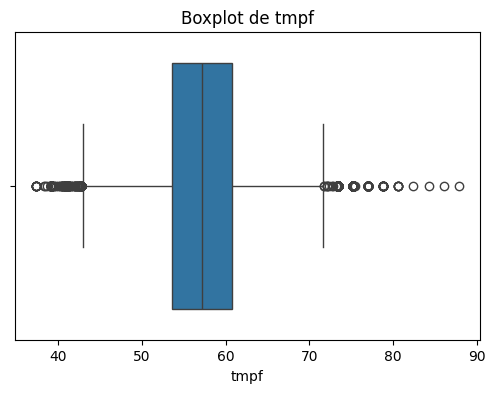

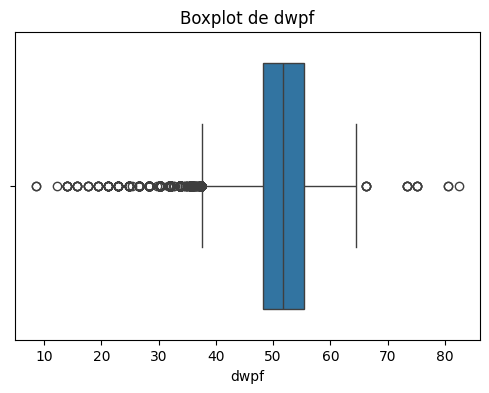

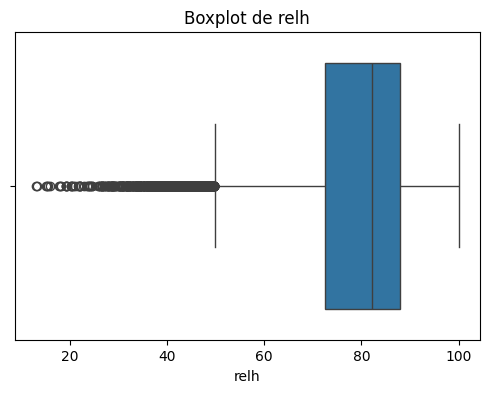

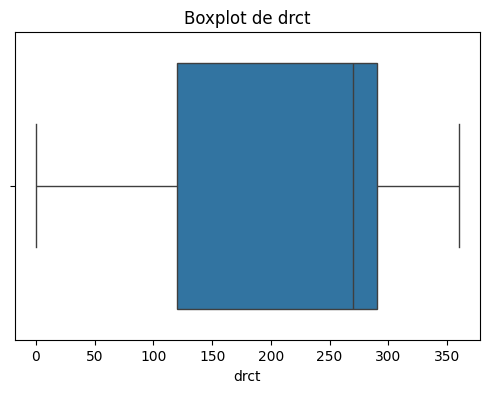

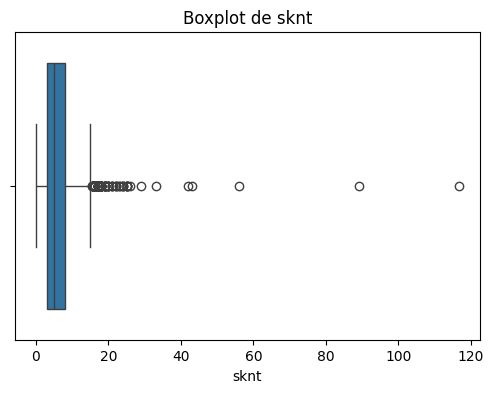

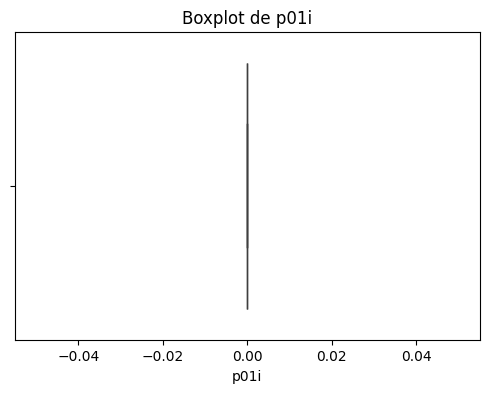

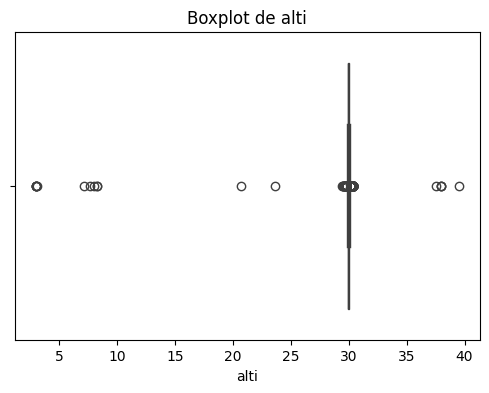

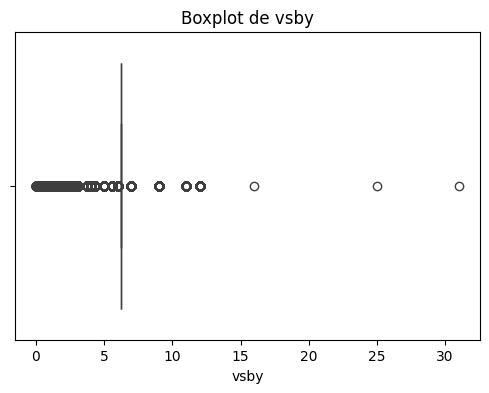

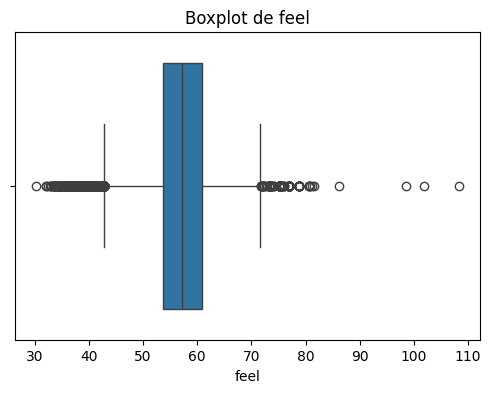

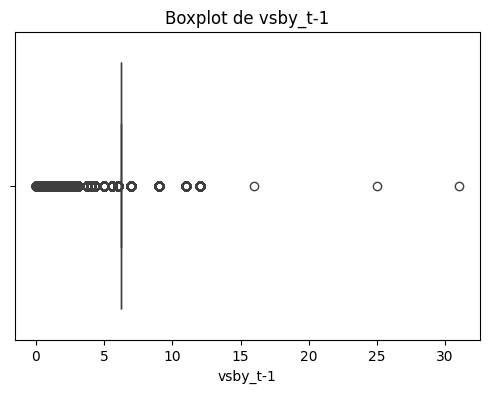

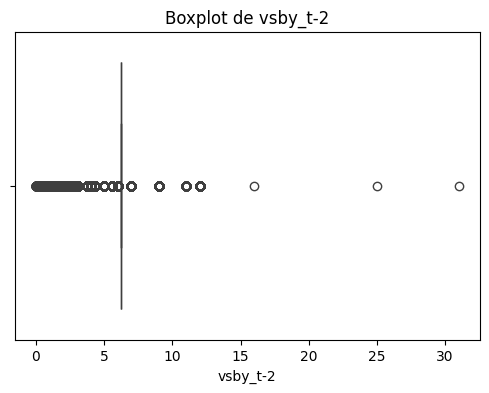

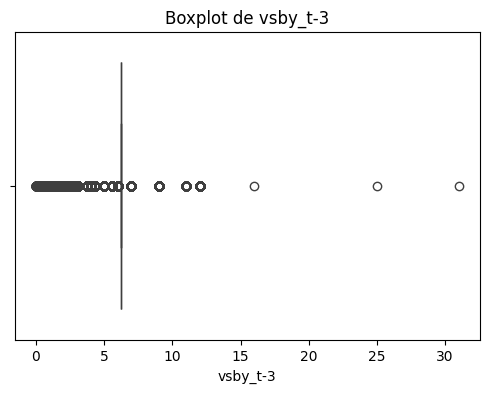

In [ ]:
#Grafico de outliers
df_metarnumericos=df_metar.select_dtypes(include=['float64'])
for col in df_metarnumericos.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_metarnumericos[col])
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()


In [ ]:
from scipy import stats

# Calcular z-score para seleccionar outliers
z_scores = np.abs(stats.zscore(df_metarnumericos, nan_policy='omit'))

df_metarsinout = df_metarnumericos[(z_scores < 3).all(axis=1)]
#(Aun esta en discusión como tratar con los outliers, el acuerdo preliminar es borrarlos,se recomienda aquello en esta situacion?)

## Creación de variable target: aeropueto abierto o cerrado bajo cierta visibilidad, en este caso 1 milla

In [ ]:
# Creación de nueva columna target 'aeropuerto_disponible'
df_metar['aeropuerto_disponible'] = df_metar['vsby'].apply(lambda x: 'sí' if x >= 1 else 'no')


In [ ]:
df_metar.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,feel,metar,vsby_t-1,vsby_t-2,vsby_t-3,mes,estacion,aeropuerto_disponible
0,SCSE,2010-01-01 00:00:00,60.8,55.4,82.37,310.0,7.0,0.0,30.00,6.21,60.8,SCSE 010000Z AUTO 31007KT 16/13 A3000 RMK T016...,6.21,6.21,6.21,1,verano,sí
1,SCSE,2010-01-01 01:00:00,59.0,55.4,87.83,290.0,5.0,0.0,30.00,6.21,59.0,SCSE 010100Z AUTO 29005KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,sí
2,SCSE,2010-01-01 02:00:00,59.0,55.4,87.83,300.0,3.0,0.0,30.00,6.21,59.0,SCSE 010200Z AUTO 30003KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,sí
3,SCSE,2010-01-01 03:00:00,59.0,55.4,87.83,270.0,3.0,0.0,30.03,6.21,59.0,SCSE 010300Z AUTO 27003KT 15/13 A3003 RMK T015...,6.21,6.21,6.21,1,verano,sí
4,SCSE,2010-01-01 04:00:00,59.0,55.4,87.83,270.0,1.0,0.0,30.00,6.21,59.0,SCSE 010400Z AUTO 27001KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,sí


In [ ]:
df_metar['aeropuerto_disponible'].value_counts()

,count
aeropuerto_disponible,
sí,114845
no,2338


## Descripción de cada feature (post EDA)

In [ ]:
pd.DataFrame(df_metar.columns, columns=["Features"])

,Features
0,station
1,valid
2,tmpf
3,dwpf
4,relh
5,drct
6,sknt
7,p01i
8,alti
9,vsby



*   station:
ID del aeropuerto. SCSE es el aeropuerto de La Serena
*   valid:
Fecha y hora de la observación
*  tmpf:
Temperatura del aire en Fahrenheit
*  dwpf:
Temperatura del "punto de rocío" en grados Fahrenheit
* relh:
Humedad relativa en %
* drct:
Dirección del viento en grados desde el norte *true*
* sknt:
Velocidad del viento en nudos
* p01i:
Precipitación horaria desde la hora de observación hasta la hora del último reinicio de la precipitación horaria. Los valores se expresan en pulgadas.
* alti:
Presión del altímetro en pulgadas
* vsby:
Visibilidad en millas de la observación, momento t
* vsby_t-1:
Visibilidad en millas de la observación, momento t-1
* vsby_t-2:
Visibilidad en millas de la observación, momento t-2
* vsby_t-3:
Visibilidad en millas de la observación, momento t-3
* feel:
Temperatura aparente (sensación térmica o índice de calor) en grados Fahrenheit
* metar:
Observación reportada sin procesar en formato METAR
* aeropuerto_disponible:
Variable dummy = 1 si es que las condiciones metereologicas de visibilidad permiten que el aeropuerto esté abierto para salida y llegada de vuelos. Variable = 0 si es que las condiciones metereologicas de visibilidad **NO** permiten que el aeropuerto esté abierto para salida y llegada de vuelos


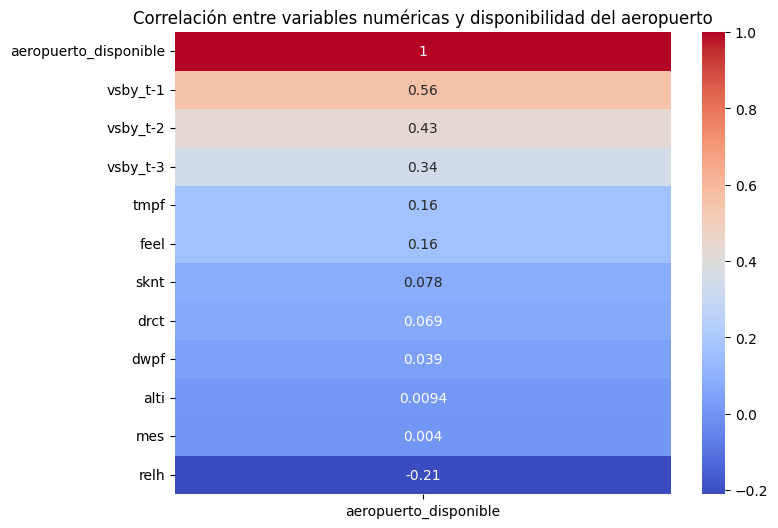

In [ ]:
#Matriz de correlación con variables numericas
df2_metar = df_metar.copy()
variables_numericas = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby_t-1', 'vsby_t-2', 'vsby_t-3', 'feel', 'mes', 'aeropuerto_disponible']
df_corr = df2_metar[variables_numericas]

# Matriz de correlación
corr_matrix = df_corr.corr()

# Heatmap solo respecto al target
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix[['aeropuerto_disponible']].sort_values(by='aeropuerto_disponible', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas y disponibilidad del aeropuerto')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


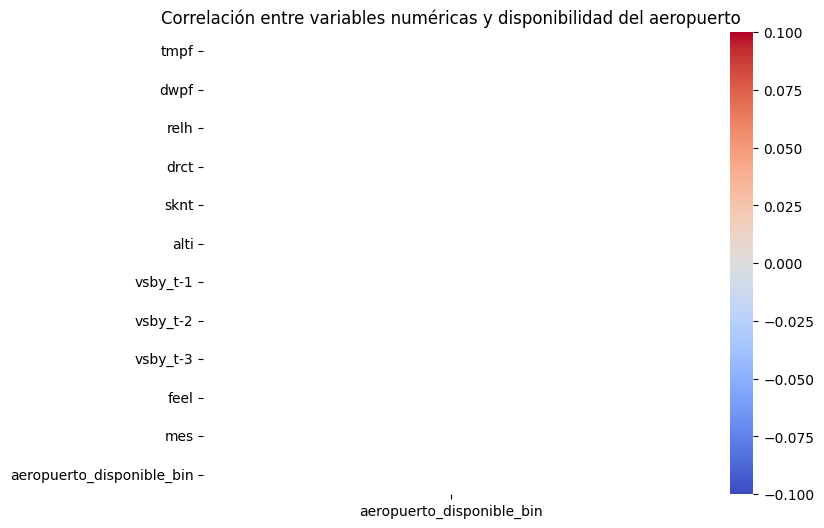

In [ ]:
#Matriz de correlación entre target y atributos
df2_metar['aeropuerto_disponible'] = df2_metar['aeropuerto_disponible'].astype(str)
df2_metar['aeropuerto_disponible_bin'] = df2_metar['aeropuerto_disponible'].map({'no': 0, 'sí': 1})

variables_numericas = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby_t-1', 'vsby_t-2', 'vsby_t-3', 'feel', 'mes', 'aeropuerto_disponible_bin']
df_corr = df2_metar[variables_numericas]

corr_matrix = df_corr.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix[['aeropuerto_disponible_bin']].sort_values(by='aeropuerto_disponible_bin', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas y disponibilidad del aeropuerto')
plt.show()

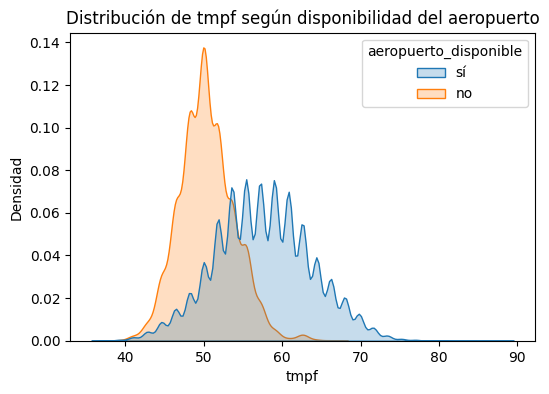

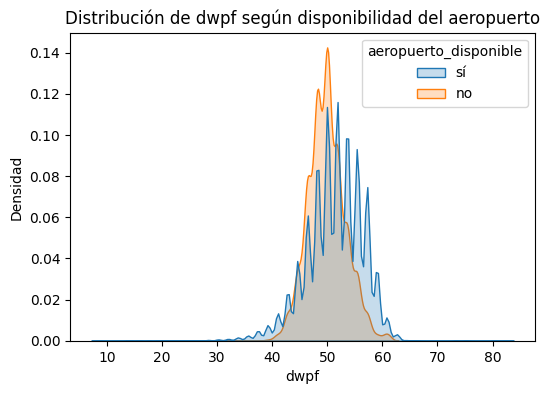

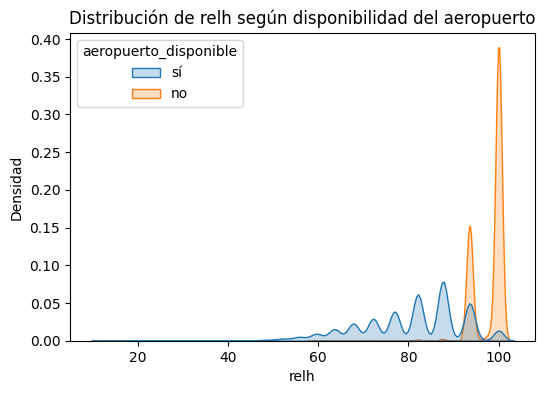

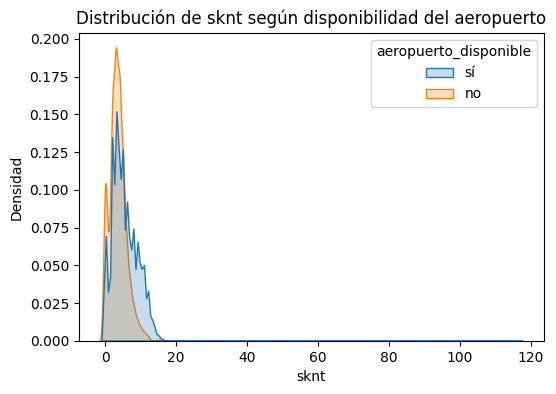

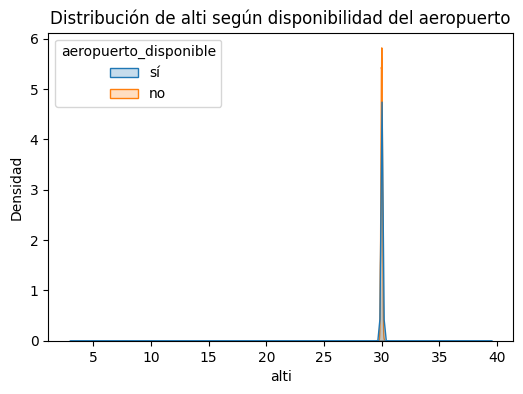

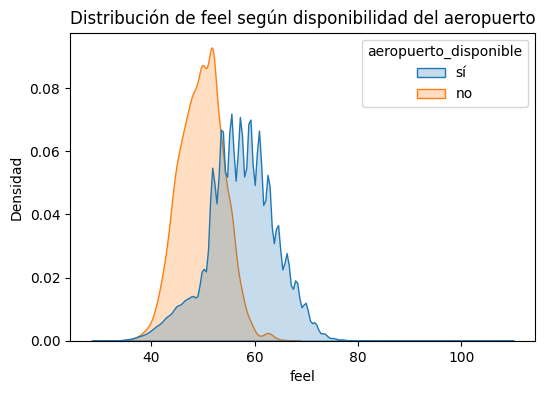

In [ ]:
#Distribucione por clase
variables_plot = ['tmpf', 'dwpf', 'relh', 'sknt', 'alti', 'feel']

# Gráficos de densidad por clase
for var in variables_plot:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df2_metar, x=var, hue='aeropuerto_disponible', fill=True, common_norm=False)
    plt.title(f'Distribución de {var} según disponibilidad del aeropuerto')
    plt.xlabel(var)
    plt.ylabel('Densidad')
    plt.show()

## Feature Engineering


In [ ]:
df_metar.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,feel,metar,vsby_t-1,vsby_t-2,vsby_t-3,mes,estacion,aeropuerto_disponible
0,SCSE,2010-01-01 00:00:00,60.8,55.4,82.37,310.0,7.0,0.0,30.00,6.21,60.8,SCSE 010000Z AUTO 31007KT 16/13 A3000 RMK T016...,6.21,6.21,6.21,1,verano,sí
1,SCSE,2010-01-01 01:00:00,59.0,55.4,87.83,290.0,5.0,0.0,30.00,6.21,59.0,SCSE 010100Z AUTO 29005KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,sí
2,SCSE,2010-01-01 02:00:00,59.0,55.4,87.83,300.0,3.0,0.0,30.00,6.21,59.0,SCSE 010200Z AUTO 30003KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,sí
3,SCSE,2010-01-01 03:00:00,59.0,55.4,87.83,270.0,3.0,0.0,30.03,6.21,59.0,SCSE 010300Z AUTO 27003KT 15/13 A3003 RMK T015...,6.21,6.21,6.21,1,verano,sí
4,SCSE,2010-01-01 04:00:00,59.0,55.4,87.83,270.0,1.0,0.0,30.00,6.21,59.0,SCSE 010400Z AUTO 27001KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,sí


In [ ]:
df_metar.select_dtypes(include='object').nunique()

,0
station,1
metar,117096
estacion,4
aeropuerto_disponible,2


In [ ]:
#1. Transformar variables categóricas con 2 valores a numeric
cols_2opt = ['aeropuerto_disponible']

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

df_metar['aeropuerto_disponible']

,aeropuerto_disponible
0,sí
1,sí
2,sí
3,sí
4,sí
...,...
117178,sí
117179,sí
117180,sí
117181,sí


In [ ]:
df_metar['aeropuerto_disponible'] = label_encoder.fit_transform(df_metar['aeropuerto_disponible'])

df_metar['aeropuerto_disponible']

,aeropuerto_disponible
0,1
1,1
2,1
3,1
4,1
...,...
117178,1
117179,1
117180,1
117181,1


In [ ]:
for col in cols_2opt:
    df_metar[col] = label_encoder.fit_transform(df_metar[col])

In [ ]:
df_metar.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,feel,metar,vsby_t-1,vsby_t-2,vsby_t-3,mes,estacion,aeropuerto_disponible
0,SCSE,2010-01-01 00:00:00,60.8,55.4,82.37,310.0,7.0,0.0,30.00,6.21,60.8,SCSE 010000Z AUTO 31007KT 16/13 A3000 RMK T016...,6.21,6.21,6.21,1,verano,1
1,SCSE,2010-01-01 01:00:00,59.0,55.4,87.83,290.0,5.0,0.0,30.00,6.21,59.0,SCSE 010100Z AUTO 29005KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,1
2,SCSE,2010-01-01 02:00:00,59.0,55.4,87.83,300.0,3.0,0.0,30.00,6.21,59.0,SCSE 010200Z AUTO 30003KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,1
3,SCSE,2010-01-01 03:00:00,59.0,55.4,87.83,270.0,3.0,0.0,30.03,6.21,59.0,SCSE 010300Z AUTO 27003KT 15/13 A3003 RMK T015...,6.21,6.21,6.21,1,verano,1
4,SCSE,2010-01-01 04:00:00,59.0,55.4,87.83,270.0,1.0,0.0,30.00,6.21,59.0,SCSE 010400Z AUTO 27001KT 15/13 A3000 RMK T015...,6.21,6.21,6.21,1,verano,1


In [ ]:
#2. Creación de dummies para variables categoricas de 3 o más valores
cols_categ = ['estacion']  #es la única

pd.get_dummies(df_metar, columns=['estacion'], drop_first=True)

for var in cols_categ:
    df_metar = pd.concat([df_metar, pd.get_dummies(df_metar[var], prefix=var)], axis=1)
    del df_metar[var]   #se elimina la variable original


In [ ]:
df_metar.head()

In [ ]:
#3. Eliminar variables irrelevantes
df_metar.describe()

In [ ]:
df_metar = df_metar.drop(columns=['station', 'metar','p01i'])

In [ ]:
df_metar.columns

In [ ]:
#4. Normalizar variables
df_metar.select_dtypes(include=['float64', 'int64']).columns.tolist()

['tmpf',
 'dwpf',
 'relh',
 'drct',
 'sknt',
 'p01i',
 'alti',
 'vsby',
 'feel',
 'vsby_t-1',
 'vsby_t-2',
 'vsby_t-3',
 'aeropuerto_disponible']

In [ ]:
var_norm = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby',
            'feel', 'vsby_t-1', 'vsby_t-2', 'vsby_t-3']  #dejo fuera variable objetivo


for var in var_norm:
    df_metar[var] = (df_metar[var] - df_metar[var].min()) / (df_metar[var].max() - df_metar[var].min())

In [ ]:
df_metar.describe()



## Modelo 1: Random Forest



In [ ]:
### ENTRENAMIENTO ###

#se separa la variable objetivo.
#Se elimina de X variable en formato fecha
#Se elimina de X vsby en momento t y pasados, dejarlos provoca porcentajes de acurracy en testeo MUY altos
X = df_metar.drop(columns=['aeropuerto_disponible', 'valid', 'vsby', 'vsby_t-1', 'vsby_t-2', 'vsby_t-3', 'station', 'metar', 'estacion_otoño', 'estacion_primavera', 'estacion_verano', 'mes'])
y = df_metar['aeropuerto_disponible']

In [ ]:
#chequear balanceo de target
y.value_counts(normalize=True)    #la variable está MUY desbalanceada

,proportion
aeropuerto_disponible,
1,0.980048
0,0.019952


In [ ]:
#disminuir proporcion de aeropuerto_disponible =1
!pip install -q imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler

#se reduce aleatoriamente la clase de mayor proporcion
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print(y_resampled.value_counts(normalize=True))


aeropuerto_disponible
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
#librerías
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
#dividir data de entrenamiento y testeo
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=12)
X_train.shape, X_test.shape

((3507, 12), (1169, 12))

In [ ]:
#modelo
rf = RandomForestClassifier(random_state=12, criterion='entropy')
rf.fit(X_train, y_train)

ValueError: could not convert string to float: 'SCSE'

In [ ]:
### PERFORMANCE ###

#métricas 1

#accurracy
rf.score(X_train, y_train) #en el set de entrenamiento

In [ ]:
rf.score(X_test, y_test) #en el set de testeo

In [ ]:

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, classification_report
import numpy as np

y_pred = rf.predict(X_test)
#Auc
y_proba = rf.predict_proba(X_test)[:, 1]  # Probabilidad de aeropuerto abierto

# Métricas
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


In [ ]:
f1, auc, mae, rmse

In [ ]:
#metrica 2
#ver cuantas observaciones el modelo predice bien
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))    #22 falsos positivos y 77 falsos negativos

print(classification_report(y_test, y_pred))  #otras métricas


In [ ]:
#metrica 3
#árbol de desición para comparar
tree_clf = DecisionTreeClassifier(random_state = 12)
tree_clf.fit(X_train, y_train)

tree_clf.score(X_test, y_test) #accuracy en set de testeo

In [ ]:
#hiperparámetros que maximizan el accuracy
param_grid = [{"n_estimators":[100, 1000] ,'max_depth': [10, 50, 100], 'min_samples_leaf': [2, 4,]},] #combinación de parámetros
rf = RandomForestClassifier(random_state = 12, criterion='entropy')

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring = 'accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)
grid_search.best_params_    #los mejores hiperparámetros encontrados

In [ ]:
grid_search.score(X_test, y_test)    #accuracy en set de testeo

In [ ]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 12, criterion='entropy', max_depth = 50, min_samples_leaf = 2)
rf.fit(X_train, y_train)

rf.score(X_test, y_test)     #accuracy final del modelo de arbol, en set de testeo

In [ ]:
#tiempo de cómputo  FALTA POR COMPLETAR

In [ ]:
### INTERPRETABILIDAD ###  para modelo de clasificación
#variables mas importantes al predecir
importancia = rf.feature_importances_
ft_variables = X_train.columns
feat_imp = pd.Series(importancia, index=ft_variables).sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(10,6))
feat_imp.head(15).plot(kind='bar')
plt.title("Importancia de las variables (Random Forest)")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

In [ ]:
#grado de efecividad del modelo al predecir, por clase
matriz = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()             #lo mismo de antes (22 falsos positivos y 77 falsos negativos) pero graficado




## Modelo 2: Multilayer Percepton



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_california_housing

from sklearn.neural_network import MLPClassifier  #classifier porque variable objetivo es binaria

import time
from sklearn.ensemble import RandomForestRegressor

In [ ]:
### ENTRENAMIENTO ###

start_time = time.time()

MLP = MLPClassifier(random_state=12, max_iter=500)
MLP.fit(X_train, y_train)

end_time = time.time()
tiempo_computo = end_time - start_time
minutes, seconds = divmod(tiempo_computo, 60)

print(f"Tiempo de ejecución: {int(minutes)} minutos y {seconds:.4f} segundos")

MLP.score(X_test, y_test) #accuracy sobre set de testeo

ValueError: could not convert string to float: 'invierno'

In [ ]:
MLP.n_layers_   #numero total de capas

In [ ]:
MLP.n_outputs_

In [ ]:
#buscar mejoras a la red

#capas ocultas
from sklearn.model_selection import GridSearchCV

start_time = time.time()

# Buscamos los hiperparámetros que maximizan accuracy del set de entrenamiento
param_grid = [{"hidden_layer_sizes":[
      (817,817),
      (163,163),
      (15,15),
      (8,8),
      (6,6),
      (2,2)  # Combinación de parámetros
    ]},]

MLP = MLPClassifier(random_state = 12)

grid_search = GridSearchCV(MLP, param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)  # Entrenamos el grid search

end_time = time.time()
execution_time_seconds = end_time - start_time
minutes, seconds = divmod(execution_time_seconds, 60)

print(f"Tiempo de ejecución: {int(minutes)} minutos y {seconds:.4f} segundos")   #6min y 44seg

grid_search.best_params_

In [ ]:
start_time = time.time()

MLP = MLPClassifier(random_state = 12, hidden_layer_sizes=(15,15))
MLP.fit(X_train, y_train)


end_time = time.time()
tiempo_de_computo = end_time - start_time
minutes, seconds = divmod(tiempo_de_computo, 60)

print(f"Tiempo de cómputo: {int(minutes)} minutos y {seconds:.4f} segundos")

MLP.score(X_test, y_test)                 #accuracy en set de testeo, no mejora

In [ ]:
#configurar funcion de activacion
MLP = MLPClassifier(random_state = 12, activation='logistic')#act 1

MLP.fit(X_train, y_train)
MLP.score(X_test, y_test)                   #accuracy en set de testeo

In [ ]:
MLP = MLPClassifier(random_state = 12, activation='tanh')#act 2

MLP.fit(X_train, y_train)
MLP.score(X_test, y_test)                   #no se observan mejoras

In [ ]:
### PERFORMANCE ###
#ya tenemos accuracy

y_pred = rf.predict(X_test)

#Auc
y_proba = rf.predict_proba(X_test)[:, 1]  # Probabilidad de aeropuerto abierto

# Métricas
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
f1, auc, mae, rmse

In [ ]:
### INTERPRETABILIDAD ###

#permutacion de variables para observar la importancia de cada una en la predicción
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

#importancia por permutación
resultado = permutation_importance(MLP, X_test, y_test, scoring='f1', n_repeats=10, random_state=42)   #será en función de métrica f1

#df con importancias
df_imp = pd.Series(resultado.importances_mean, index=X_test.columns).sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(10,6))
df_imp.head(15).plot(kind='bar')
plt.title("Importancia de las variables")
plt.tight_layout()
plt.show()

In [ ]:
#grado de efectividad del modelo al predecir, por clase
y_pred = MLP.predict(X_test)


matriz = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()     #45 falsos positivos y 65 falsos negativos

# Modelo 3: XGBoost

In [ ]:
#utilizamos la misma división que para modelo de RF

X = df_metar.drop(columns=['aeropuerto_disponible', 'valid', 'vsby', 'vsby_t-1', 'vsby_t-2', 'vsby_t-3'])
y = df_metar['aeropuerto_disponible']

In [ ]:
#importación de librerías a utilizar
!pip install imbalanced-learn shap

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [ ]:
# Separar data en testeo y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [ ]:
y.value_counts(normalize=True)

In [ ]:
# Balanceo con SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [ ]:
# GridSearchCV para XGBoost
param_grid = {
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01]
}
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid = GridSearchCV(model, param_grid, scoring='f1', cv=3, verbose=1)

start = time.time()
grid.fit(X_train_bal, y_train_bal)
end = time.time()

# Mejor modelo
best_model = grid.best_estimator_

# Predicciones
y_pred = best_model.predict(X_test)

# Reporte de métricas
print("Mejores hiperparámetros:", grid.best_params_)  # <-- ESTA ES LA LÍNEA CLAVE
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))
print("Tiempo de entrenamiento:", round(end - start, 2), "segundos")



Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:51:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:51:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:51:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:51:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:51:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.84      0.32       578
           1       1.00      0.93      0.96     28718

    accuracy                           0.93     29296
   macro avg       0.60      0.88      0.64     29296
weighted avg       0.98      0.93      0.95     29296

F1 Score: 0.9638220591937282
AUC Score: 0.9645720309483629
Tiempo de entrenamiento: 22.39 segundos


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9313216821409066


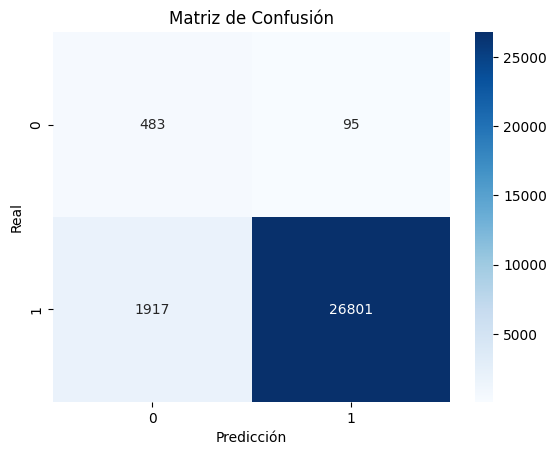

In [ ]:
# Matriz de Confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

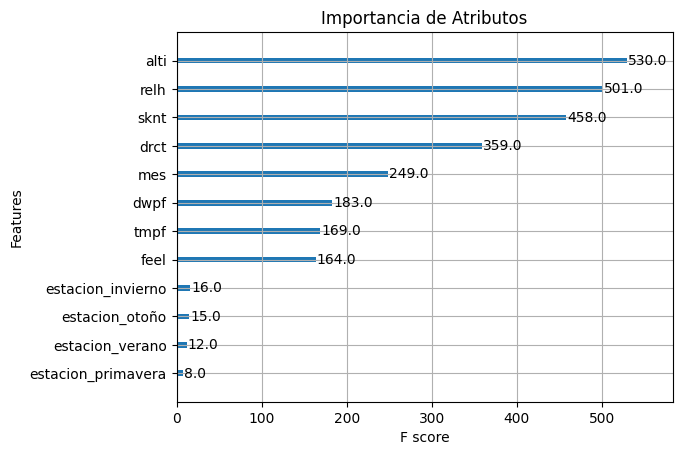

In [ ]:
# Importancia
xgb.plot_importance(best_model)
plt.title("Importancia de Atributos")
plt.show()

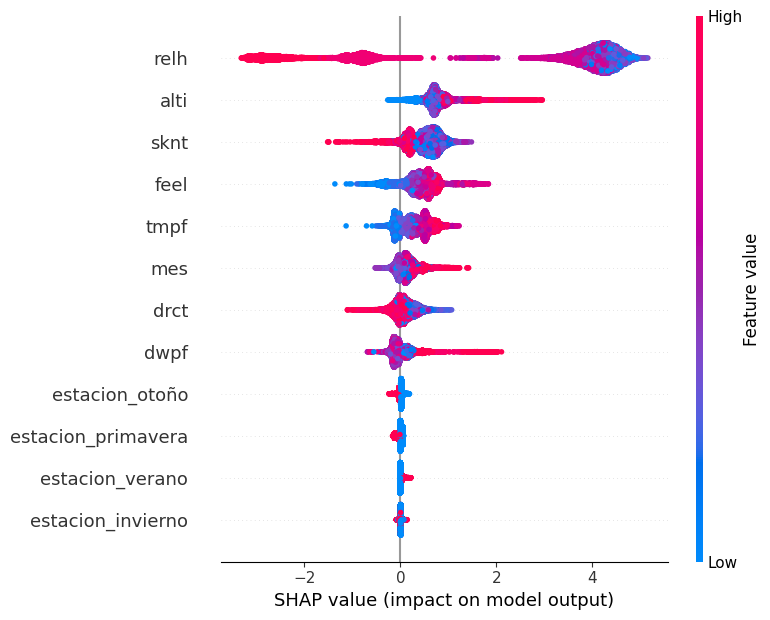

In [ ]:
import shap

X_test_numeric = X_test.copy()
X_test_numeric = X_test_numeric.apply(pd.to_numeric, errors='coerce')
X_test_numeric = X_test_numeric.fillna(0)


explainer = shap.TreeExplainer(best_model)


shap_values = explainer.shap_values(X_test_numeric)

#gráfico beeswarm
shap.summary_plot(shap_values, X_test_numeric)
